# Hog with Svm

## import libiraries

In [24]:
import numpy as np
import tensorflow_datasets as tfds
import cv2
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import random

## Load and split data

In [5]:
dataset, info = tfds.load('caltech101', with_info=True, as_supervised=True)

train_data = dataset['train']
test_data = dataset['test']

## Resize the image to a fixed size (for consistent feature extraction)


In [7]:
def resize_with_padding(image, target_size=(64, 64)):
    h, w = image.shape[:2]
    scale = min(target_size[1] / w, target_size[0] / h)
    resized_image = cv2.resize(image, (int(w * scale), int(h * scale)))
    
    delta_w = target_size[1] - resized_image.shape[1]
    delta_h = target_size[0] - resized_image.shape[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_image

## Extract HOG features from the images


In [9]:
def extract_hog_features_cv2(image):
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Define HOGDescriptor parameters
    winSize = (32, 32)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9

    # Initialize the HOGDescriptor
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

    # Compute HOG features
    hog_features = hog.compute(gray_image)

    return hog_features  # Return the feature vector

## Preprocess the data and extract features



In [11]:
def process_data(data, image_size=(64, 64)):
    images = []
    labels = []

    for image, label in data:
        # Resize the image to the desired size
        image_resized = resize_with_padding(image.numpy(), image_size)
        
        # Extract HOG features
        hog_features = extract_hog_features_cv2(image_resized)
        
        images.append(hog_features.flatten())
        labels.append(label.numpy())
    
    return np.array(images), np.array(labels)

## Preprocess the training and testing datasets


In [13]:
X_train, y_train = process_data(train_data, image_size=(64, 64))
X_test, y_test = process_data(test_data, image_size=(64, 64))

##  Feature Scaling



In [15]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Training the Kernel SVM model on the Training set



In [17]:
classifier = SVC(kernel='linear', random_state=0)
classifier.fit(X_train, y_train)


SVC(kernel='linear', random_state=0)

## Predict the labels for the test set


In [19]:
y_pred = classifier.predict(X_test)


## Calculate accuracy

In [21]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 65.09%


## Print classification report


In [26]:
print("\nClassification Report:")
print(classification_report(y_test.flatten(), y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        25
           1       0.98      0.95      0.97       770
           2       0.13      0.25      0.17        12
           3       0.00      0.00      0.00        12
           4       0.64      0.16      0.25       438
           5       0.21      0.35      0.27        17
           6       0.17      0.42      0.24        24
           7       0.05      0.19      0.08        16
           8       0.06      0.33      0.10         3
           9       0.54      0.42      0.47        98
          10       0.63      0.47      0.54        68
          11       0.07      0.15      0.09        13
          12       0.64      0.64      0.64        55
          13       0.50      0.48      0.49        61
          14       0.31      0.45      0.37        20
          15       0.10      0.38      0.16        13
          16       0.98      0.96      0.97        93
   

## Visualize a random image, its HOG features, and the SVM prediction


In [46]:
def show_image_with_hog_and_prediction(data, classifier, scaler, image_size=(64, 64)):
    # Randomly select an example from the dataset
    for image, label in data.take(1):
        original_image = image.numpy()
        true_label = label.numpy()
    
    # Resize and preprocess the selected image
    resized_image = resize_with_padding(original_image, image_size)
    
    # Extract HOG features for visualization
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2GRAY)
    _, hog_image = hog(
        gray_image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=True,
        # multichannel=False,
    )
    hog_features = extract_hog_features_cv2(resized_image).flatten()
    
    # Prepare the feature vector for SVM prediction
    hog_features = scaler.transform([hog_features])
    predicted_label = classifier.predict(hog_features)[0]
    
    # Plot the original image, HOG visualization, and the prediction
    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title(f"Original Image\nTrue Label: {true_label}")
    plt.axis("off")
    
    # HOG visualization
    plt.subplot(1, 3, 2)
    plt.imshow(hog_image, cmap="gray")
    plt.title("HOG Features")
    plt.axis("off")
    
    # Display prediction
    plt.subplot(1, 3, 3)
    plt.imshow(resized_image)
    plt.title(f"Prediction: {predicted_label}")
    plt.axis("off")
    
    plt.show()

## Display a random image, its HOG features, and the prediction


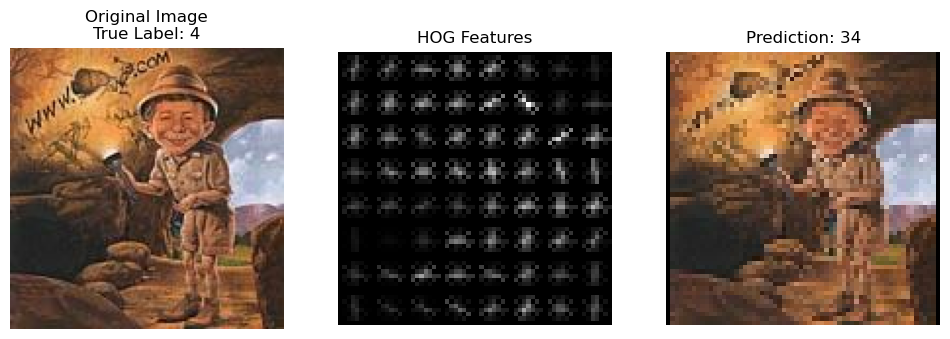

In [49]:
show_image_with_hog_and_prediction(test_data, classifier, scaler)
